# Deep Quantile Regression

One area that Deep Learning has not explored extensively is the uncertainty in estimates. Most Deep Learning frameworks currently focus on giving a best estimate as defined by a loss function. Occasionally something beyond a point estimate is required to make a decision. This is where a distribution would be useful. Bayesian statistics lends itself to this problem really well since a distribution over the dataset is inferred. However, Bayesian methods so far have been rather slow and would be expensive to apply to large datasets.
As far as decision making goes, most people actually require quantiles as opposed to true uncertainty in an estimate. For instance when measuring a child’s weight for a given age, the weight of an individual will vary. What would be interesting is (for arguments sake) the 10th and 90th percentile. Note that the uncertainty is different to quantiles in that I could request for a confidence interval on the 90th quantile. This article will purely focus on inferring quantiles.

In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np
import pandas as pd
import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K

import statsmodels.formula.api as smf   
from sklearn.linear_model import LinearRegression  

## ordinary linear regression

In ordinary linear regression, we are estimating the mean of some variable y, conditional on the values of independent variables X. As we proceed to fit the ordinary least square regression model on the data we make a key assumption about the random error term in the linear model. Our assumption is that the error term has a constant variance across the values of independent variable X.

- What happens when this assumption is no longer true ?
- Also instead of estimating the mean of our independent variable can we estimate the median or the 0.3th quantile or 0.8th quantile of our independent variable?.
This is where Quantile Regression comes to our rescue.
Let us write some code to better understand this. Let us create some data and plot it.

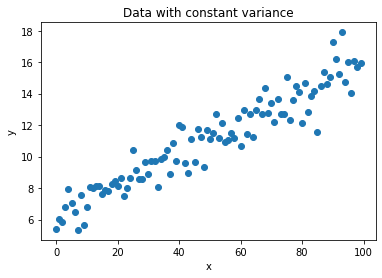

In [10]:
## Generate some data with constant variance /noise 
x = np.arange(100).reshape(100,1) 
intercept_ = 6 
slope_ = 0.1 

## non constant error 
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = 1) 

## Regression equation 
y = intercept_ + slope_ * x + error_  

plt.figure(1) 
plt.scatter(x, y) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("Data with constant variance")
plt.show()

We have one independent variable x and a dependent variable y. Our noise, error_ is gaussian with unit variance. An ordinary least square regression is the ideal candidate here to model the data.

Mean squared error: 0.85
Variance score: 0.90


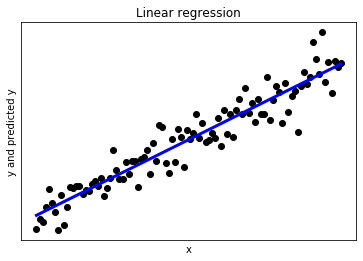

In [11]:
## Let us do a least square regression on the above dataset (sklearn)
model1 = LinearRegression(fit_intercept = True, normalize = False) 
model1.fit(x, y)  
y_pred1 = model1.predict(x)  
print("Mean squared error: {0:.2f}".format(np.mean((y_pred1 - y) ** 2))) 
print('Variance score: {0:.2f}'.format(model1.score(x, y)))  

## Plot the regression 
plt.figure(2) 
plt.scatter(x, y,  color='black') 
plt.plot(x, y_pred1, color='blue', linewidth=3)  
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y and predicted y") 
plt.title("Linear regression")
plt.show()

With a variance score of 1.0, we have modeled the data perfectly. Our plot of the regression line confirms the same.

Now let us introduce some variable noise in our data. Our noise varies based on the range of our x values.

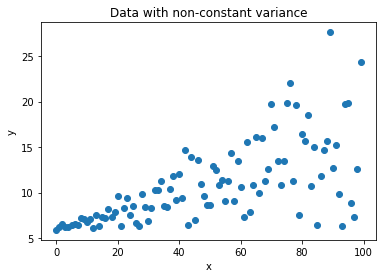

In [15]:
## Generate some data with non-constant variance 
x_ = np.arange(100).reshape(100,1) 
intercept_ = 6 
slope_ = 0.1 

## Non constant variance 
var_ = 0.1 + 0.05 * x_ 

## non constant error 
error_ = np.random.normal(size = (100,1), loc = 0.0, scale = var_) 

## Regression equation 
y_ = intercept_ + slope_ * x + error_  

plt.figure(3) 
plt.scatter(x_, y_) 
plt.xlabel("x") 
plt.ylabel("y") 
plt.title("Data with non-constant variance")
plt.show()

scale parameter for our error_ calculation is no longer 1 as in the previous case. The scale is a linear function of our x value.

This phenomenon where the variability of y is unequal across the range of values of x is called as Heteroscedasticity. As seen in the plot it takes the shape of a cone. The y variable widens as the value of x increases. Let us try to fit a linear regression to this dataset.

Mean squared error: 11.32
Variance score: 0.43


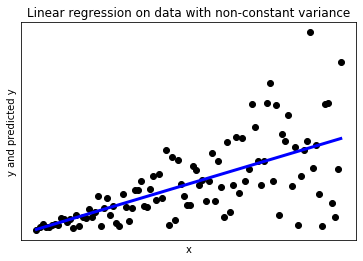

In [16]:
## Try to fit a linear regression  (sklearn)
model2 = LinearRegression(fit_intercept = True, normalize = False) 
model2.fit(x_, y_)  
y_pred2 = model2.predict(x_)  
print("Mean squared error: {0:.2f}".format(np.mean((y_pred2 - y_) ** 2))) 
print('Variance score: {0:.2f}'.format(model1.score(x_, y_)))  

## Plot the regression 
plt.figure(4) 
plt.scatter(x_, y_,  color='black') 
plt.plot(x_, y_pred2, color='blue', linewidth=3)  
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y and predicted y") 
plt.title("Linear regression on data with non-constant variance")
plt.show()

With variance score of 0.43 linear regression did not do a good job overall. When the x values are close to 0, linear regression is giving a good estimate of y, but we near end of x values the predicted y is far way from the actual values and hence becomes completely meaningless.

## Quantile Regression

Here is where Quantile Regression comes to rescue. I have used the python package statsmodels 0.8.0 for Quantile Regression.
Let us begin with finding the regression coefficients for the conditioned median, 0.5 quantile

In [49]:
## Quantile regression for the median, 0.5th quantile 
data = pd.DataFrame(data = np.hstack([x_, y_]), columns = ["x", "y"]) 
print (data.head())  
mod = smf.quantreg('y ~ x', data) 
res = mod.fit(q=.5) 
print(res.summary())

## least square regression on the above dataset (statsmodels)
ols = smf.ols('y ~ x', data).fit(q=.5)
ols_ci = ols.conf_int().loc['x'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['x'],
           lb = ols_ci[0],
           ub = ols_ci[1])

     x         y
0  0.0  5.904453
1  1.0  6.183026
2  2.0  6.537976
3  3.0  6.234400
4  4.0  6.159266
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:               0.3221
Model:                       QuantReg   Bandwidth:                       2.427
Method:                 Least Squares   Sparsity:                        6.399
Date:                Wed, 09 Oct 2019   No. Observations:                  100
Time:                        13:31:40   Df Residuals:                       98
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9276      0.635      9.333      0.000       4.667       7.188
x              0.1000      0.011      9.019      0.000       0.078       0.122


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


You see that our intercept is 5.9276 and our slope or the coefficient for our x is 0.1000. These are the parameters for the 0.5th quantile of our y. Similarly we can do the models for other quantiles.


In [37]:
## Build the model for other quantiles 
quantiles = np.arange(0.1,1,0.1) 
print (quantiles)
models = [] 
params = []  
for qt in quantiles:  
    #print (qt)  
    res = mod.fit(q = qt )    
    models.append(res)    
    params.append([qt, res.params['Intercept'], 
                   res.params['x']] + res.conf_int().ix['x'].tolist())   
params = pd.DataFrame(data = params, 
                      columns = ['qt','intercept','x_coef','cf_lower_bound','cf_upper_bound'])  
print (params)

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
    qt  intercept    x_coef  cf_lower_bound  cf_upper_bound
0  0.1   5.986128  0.021345       -0.006555        0.049245
1  0.2   5.943134  0.054036        0.032354        0.075718
2  0.3   6.049333  0.067056        0.045972        0.088140
3  0.4   6.005586  0.076272        0.053750        0.098794
4  0.5   5.927575  0.099963        0.077968        0.121958
5  0.6   5.904453  0.110511        0.088872        0.132151
6  0.7   5.821317  0.137694        0.113707        0.161681
7  0.8   5.796808  0.155802        0.129914        0.181691
8  0.9   5.904452  0.182401        0.151084        0.213718


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


As you see in the above output, our intercept value for the 0.1th quantile is 5.986128, slope is 0.021345 and we also have the lower and the upper bound aka the intervals of our x intercept value.

Let us plot 0.1th, 0.5th and 0.9th quantile models against our original data.

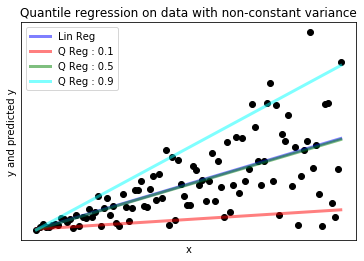

In [40]:
plt.figure(5) 
plt.scatter(x_, y_,  color='black') 
plt.plot(x_, y_pred2, color='blue', linewidth=3, label='Lin Reg', alpha=0.5)  
y_pred3 = models[0].params['Intercept'] + models[0].params['x'] * x_ 
plt.plot(x_, y_pred3, color='red', linewidth=3, label='Q Reg : 0.1', alpha=0.5)  
y_pred4 = models[4].params['Intercept'] + models[4].params['x'] * x_ 
plt.plot(x_, y_pred4, color='green', linewidth=3, label='Q Reg : 0.5', alpha=0.5)   
y_pred5 = models[8].params['Intercept'] + models[8].params['x'] * x_ 
plt.plot(x_, y_pred5, color='cyan', linewidth=3, label='Q Reg : 0.9', alpha=0.5)   
plt.xticks(()) 
plt.yticks(()) 
plt.xlabel("x") 
plt.ylabel("y and predicted y") 
plt.title("Quantile regression on data with non-constant variance") 
plt.legend()
plt.show()

The Ordinary Linear regression model is plotted in blue colored line. You can compare that model with other quantile models.

Another interesting way to visualize is the slope values and their upper/lower bounds for different quantiles.

<Figure size 432x288 with 0 Axes>

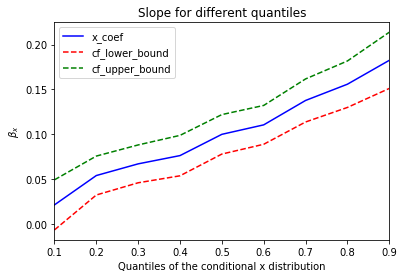

In [72]:
## Plot the changes in the quantile coefficients 
plt.figure(6) 
ax = params.plot(x = 'qt', 
            y = ['x_coef','cf_lower_bound', 'cf_upper_bound'], 
            title = 'Slope for different quantiles', 
            kind ='line', 
            style = ['b-','r--','g--'])
ax.set_xlabel("Quantiles of the conditional x distribution")
ax.set_ylabel(r'$\beta_{x}$')
plt.show()

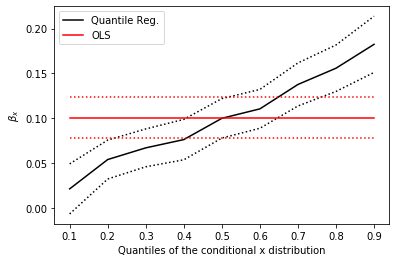

In [67]:
plt.figure(7) 
n = params.shape[0]
p1 = plt.plot(params['qt'], params['x_coef'], color='black', label='Quantile Reg.')
p2 = plt.plot(params['qt'], params['cf_upper_bound'], linestyle='dotted', color='black')
p3 = plt.plot(params['qt'], params['cf_lower_bound'], linestyle='dotted', color='black')
p4 = plt.plot(params['qt'], [ols['b']] * n, color='red', label='OLS')
p5 = plt.plot(params['qt'], [ols['lb']] * n, linestyle='dotted', color='red')
p6 = plt.plot(params['qt'], [ols['ub']] * n, linestyle='dotted', color='red')
plt.ylabel(r'$\beta_{x}$')
plt.xlabel('Quantiles of the conditional x distribution')
plt.legend()
plt.show()

Ordinary linear regression (OLS) has constant slope and confidence interval for all x.

In most cases, the quantile regression point estimates lie outside the ordinary linear regression confidence interval, which suggests that the effect of x on y may not be constant across the distribution.

## Deep Quantile Regression

In [80]:
mcycle = pd.read_csv('data/mcycle',delimiter='\t')
x_ = mcycle.times
y_ = mcycle.accel
# Standardise the inputs and outputs
x_mean=x_.mean()
x_std =x_.std()
y_mean=y_.mean()
y_std =y_.std()
x_ = (x_ - x_.mean())/x_.std()
y_ = (y_ - y_.mean())/y_.std()

In [81]:
model = Sequential()
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(units=10, input_dim=1,activation='relu'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adadelta')
model.fit(x_, y_, epochs=2000, batch_size=32, verbose=0)
model.evaluate(x_, y_)

94/94 [==============================] - 0s 789us/sample - loss: 0.7195


0.7195281399057266

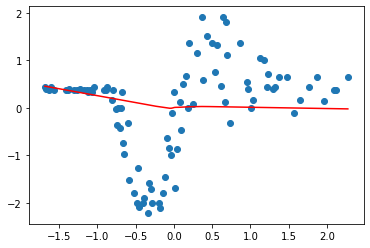

In [82]:
x_test = np.linspace(x_.min(),x_.max(),200)
y_test = model.predict(x_test)

plt.scatter(x_,y_)
plt.plot(x_test, y_test,'r')
plt.show()

In [79]:
mcycle = pd.read_csv('data/mcycle',delimiter='\t')
x_ = mcycle.times
y_ = mcycle.accel